#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import express as px
from scipy.stats import chi2_contingency

import warnings

warnings.filterwarnings("ignore")

#### Data Wrangling

In [2]:
def wrangling(path):
    # Read the data
    df = pd.read_csv(path)
    
    # Apply all cleaning operations
    df['crop_type'] = df['crop_type'].str.title().replace({'Soy': 'Soybeans'}).fillna('Unspecified Crop')
    df['soil_type'] = df['soil_type'].str.title().fillna('Unspecified Soil')
    df['irrigation_type'] = df['irrigation_type'].str.title().fillna('None')
    
    df['field_size_acres'] = df['field_size_acres'].abs()

    #df['yield_per_acre'] = df['yield_per_acre'].str.split(' ', expand = True)[2].astype(float).fillna(0)

    df['planting_date'] = pd.to_datetime(df['planting_date'], errors='coerce').dt.strftime('%Y-%m-%d')
    df['planting_date'] = pd.to_datetime(df['planting_date'])

    # Most plants survive between 15 and 30. For this project, we'll use 0 to 40
    df['temperature_celsius'] = df['temperature_celsius'].apply(lambda x: x if 0 <= x <= 40 else float('nan'))

    # PH values is between 0 and 14. Values outside this range are incorrect
    df['ph_level'] = df['ph_level'].apply(lambda x : x if x >= 0 and x <= 14 else float('nan'))
    
    df['pest_control'] = df['pest_control'].apply(lambda x : re.sub(r'L.*', '', str(x))).astype(float)

    df['fertilizer_used'] = df['fertilizer_used'].apply(lambda x : re.sub(r'k.*', '', str(x))).astype(float)

    
    return df
df = wrangling('varied_farm_data.csv')

#Populate field_id
def populate_field(df):
    field_ids = []
    
    for i in range(1, len(df) + 1):
        if i < 10:
            field = 'F00' + str(i)
        elif i < 100:
            field = 'F0' + str(i)
        else:
            field = 'F' + str(i)
        field_ids.append(field)
    
    return field_ids
df['field_id'] = populate_field(df)

In [3]:
df.head(10)

,field_id,region,season,crop_type,soil_type,field_size_acres,planting_date,temperature_celsius,rainfall_mm,yield_per_acre,ph_level,irrigation_type,fertilizer_used,pest_control
0,F001,West,Fall,Corn,Sandy Loam,105.753139,NaT,NaN,306.001900,72.661777,7.298133,Sprinkler,135.7,0.8
1,F002,Northeast,Winter,Corn,Clay Loam,69.373479,2023-12-24,10.786679,855.299595,NaN,7.271082,Drip,159.7,1.8
2,F003,Midwest,Winter,Unspecified Crop,Silt Loam,89.535571,2023-02-03,NaN,1230.015370,103.628245,7.499056,Drip,274.8,2.3
3,F004,South,Winter,Soybeans,Clay,NaN,2023-01-20,18.037213,972.868240,30.835988,7.683998,Sprinkler,168.6,1.8
4,F005,West,Spring,Wheat,Sandy Loam,101.411560,2023-03-18,NaN,443.958717,159.493012,6.249919,Sprinkler,139.5,1.6
5,F006,NaN,Fall,Corn,Sandy Loam,NaN,2023-10-21,22.016424,1032.585261,96.534691,7.021358,Sprinkler,108.2,0.5
6,F007,West,Spring,Wheat,Loamy Sand,150.655023,2023-04-25,31.110174,NaN,161.995225,7.114107,Sprinkler,125.0,2.5
7,F008,South,NaN,Corn,Sandy Loam,42.137476,2023-06-08,31.522530,813.402341,24.908853,6.430563,Sprinkler,146.6,1.6
8,F009,South,Summer,Corn,Clay,89.682257,2023-06-12,25.853866,891.109580,16.270057,6.357082,Sprinkler,170.3,2.4
9,F010,Midwest,Spring,Corn,Silt Loam,89.320668,2023-05-01,27.965398,NaN,385.246773,6.790392,Sprinkler,188.1,1.7


In [4]:
df.describe()[1:]

,field_size_acres,planting_date,temperature_celsius,rainfall_mm,yield_per_acre,ph_level,fertilizer_used,pest_control
mean,88.455513,2023-06-28 20:35:54.696132864,21.862903,818.982811,128.422868,6.561211,200.463986,1.503911
min,20.030075,2023-01-01 00:00:00,0.029859,194.855651,12.067029,5.500116,100.000000,0.500000
25%,55.493794,2023-03-27 00:00:00,16.448845,615.953364,47.173121,6.068598,150.500000,1.000000
50%,78.657587,2023-06-26 00:00:00,22.213703,813.521380,92.325193,6.556556,201.000000,1.500000
75%,115.449768,2023-09-27 00:00:00,27.745516,1011.206912,170.724808,7.060134,249.900000,2.000000
max,199.925064,2023-12-27 00:00:00,39.993641,1696.469408,502.242878,7.999531,300.000000,2.500000
std,42.261472,NaN,7.946487,276.606039,109.674539,0.595856,57.608923,0.580293


### Exploratory Data Analysis

In [5]:
corr = df.select_dtypes("number").corr()
corr

,field_size_acres,temperature_celsius,rainfall_mm,yield_per_acre,ph_level,fertilizer_used,pest_control
field_size_acres,1.000000,0.147086,-0.389086,-0.073654,-0.032386,0.017602,-0.003272
temperature_celsius,0.147086,1.000000,-0.207796,-0.141496,0.036930,0.017317,0.002964
rainfall_mm,-0.389086,-0.207796,1.000000,0.248788,0.078636,-0.012781,-0.008528
yield_per_acre,-0.073654,-0.141496,0.248788,1.000000,-0.053850,-0.006831,0.000813
ph_level,-0.032386,0.036930,0.078636,-0.053850,1.000000,-0.002938,-0.005674
fertilizer_used,0.017602,0.017317,-0.012781,-0.006831,-0.002938,1.000000,0.008030
pest_control,-0.003272,0.002964,-0.008528,0.000813,-0.005674,0.008030,1.000000


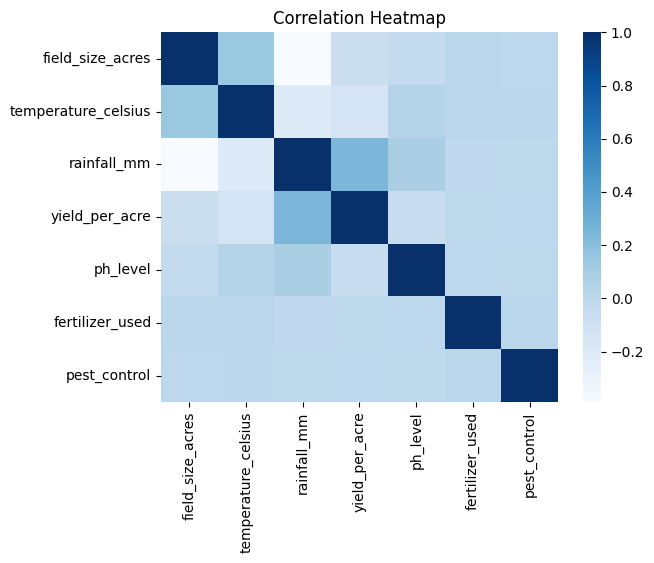

In [6]:
sns.heatmap(corr, cmap = 'Blues')
plt.title('Correlation Heatmap');

**Correlation Interpretation:**
   
   - Field size shows a weak positive correlation with temperature (0.147), suggesting a slight tendency for larger fields to be associated with higher temperatures.
   - Field size has a moderate negative correlation with rainfall (-0.389), indicating that larger fields might receive slightly less rainfall)**:
   - Temperature has a weak negative correlation with rainfall (-0.208), suggesting that as temperatures rise, rainfall might slightly decrease.
   - Temperature also shows a weak negative correlation with yield per acre (-0.141), indicating that higher temperatures might slightly reduce yield, though the effect iall (mm)**:
   - Rainfall has a moderate positive correlation with yield per acre (0.249), which suggests that more rainfall is somewhat associated with hiproductivity in this dataset.

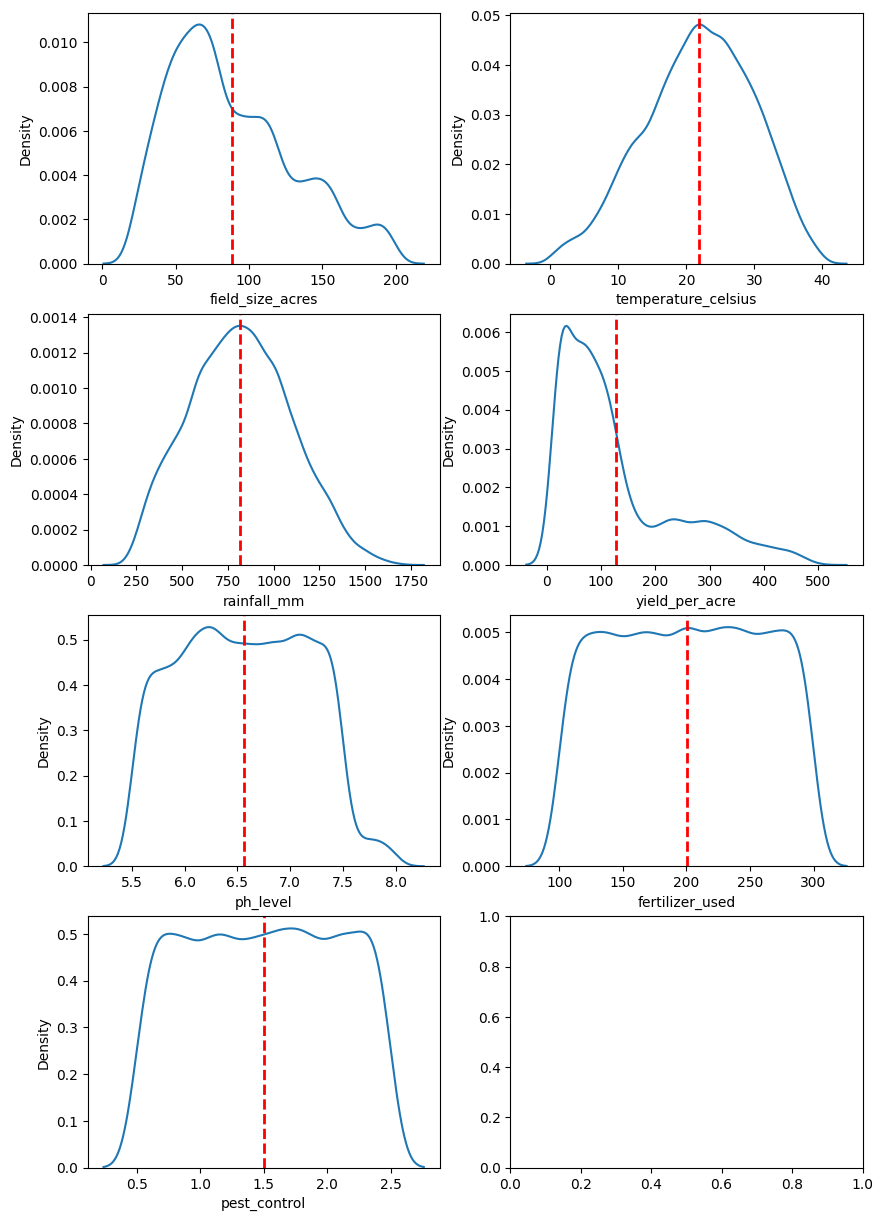

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()
numerical_cols = df.select_dtypes("number").corr().columns

for i, col in enumerate(numerical_cols):
    mean = df[col].mean()
    sns.kdeplot(data = df, x = col, ax = axes[i])
    axes[i].axvline(mean, color='red', linestyle='dashed', linewidth=2)


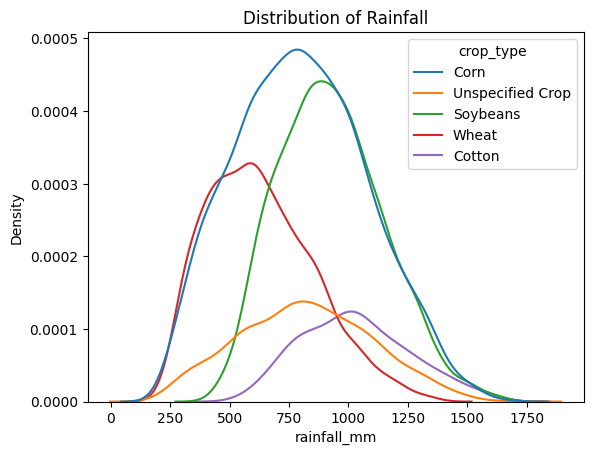

In [8]:
sns.kdeplot(data=df, x='rainfall_mm', hue='crop_type')
plt.title("Distribution of Rainfall");

This KDE plot shows the distribution of rainfall (in millimeters) across different crop types:
- All crops show a roughly normal distribution of rainfall
- Corn and Soybeans have very similar rainfall distributions with the highest peaks around 750-800mm
- Wheat has a lower peak of 550 but similar distribution shape
- Cotton has the highest peak around 1000 mm but with a smaller density
- All crops show high variabiity
This means that there are less fields planting Cotton at its peak rainfall than other crops

The high variability for all crops mean that each crop can adapt to a broad range of rainfall conditions. 
i.e. although each crop has an ideal peak rainfall, we can explore some other viable regions where rainfall varies significantly from their optimal level

<Axes: xlabel='season', ylabel='rainfall_mm'>

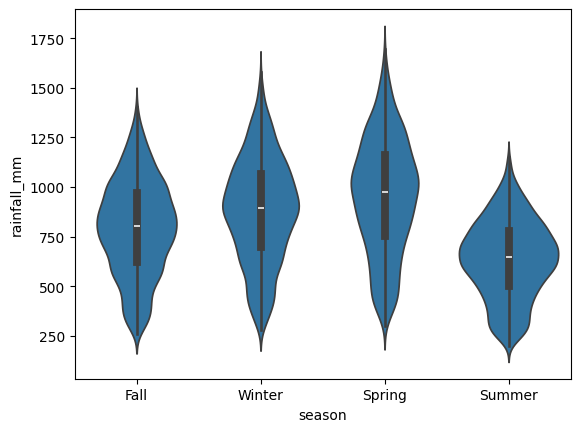

In [9]:
sns.violinplot(data=df, y='rainfall_mm', x='season')

**Interpretation**
- **Fall**: Rainfall mostly varies between 250 and 1300 mm, with a peak near the middle of this range.
- **Winter**: Rainfall also ranges from around 250 to 1500 mm, with a similar distribution shape to fall but slightly more concentrated near 800 mm.
- **Spring**: Rainfall has the widest range, from about 250 to 1700 mm, with peaks around 1000
- **Summer**: Rainfall is lower overall, ranging from 250 to 1000 mm, making it the driest season.

Spring and ing  have the highest and most variable rainfall, making them more favorable for water-dependent crops. Summer is relatively dry, so it might be less ideal for planting

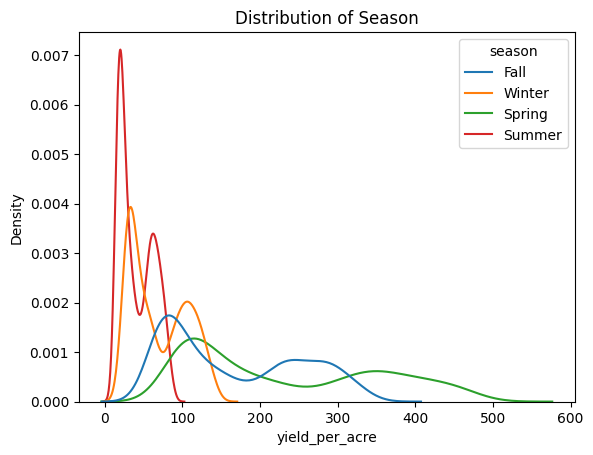

In [10]:
sns.kdeplot(data=df, x='yield_per_acre', hue='season')
plt.title("Distribution of Season");

**Interpretation:**
- **Summer:** Yield is low with variation from 0 and 100 with peaks at 25 per acre and 75 per acre. Summer may not be ideal for planting due to limited productivity.
- **Winter:** Yield peaks around 50 per acre with higher variability (0 to 150) than Summer. This shows moderate improvement but still lower productivity than Spring and Fall
- **Spring:** Yields vary widely, from 0 to 550, with a high peak at 110. This makes spring the best season for planting.
**Fall:** Yields range from 0 to 400, with peaks at 90 and between 220 and 300, making fall also good for planting.

Spring and fall are best for planting, while summer and winter may need support for higher productivity.

In [30]:
contingency_table = pd.crosstab(df['soil_type'], df['crop_type'])
print(contingency_table)

crop_type         Corn  Cotton  Soybeans  Unspecified Crop  Wheat
soil_type                                                        
Clay               453     492       487               170      0
Clay Loam         1233       0      1222               329    514
Loamy Sand         735       0         0               161    751
Sandy Loam        1237     470       463               353    729
Silt Loam         1243       0      1187               305    498
Unspecified Soil   507     114       390               156    319


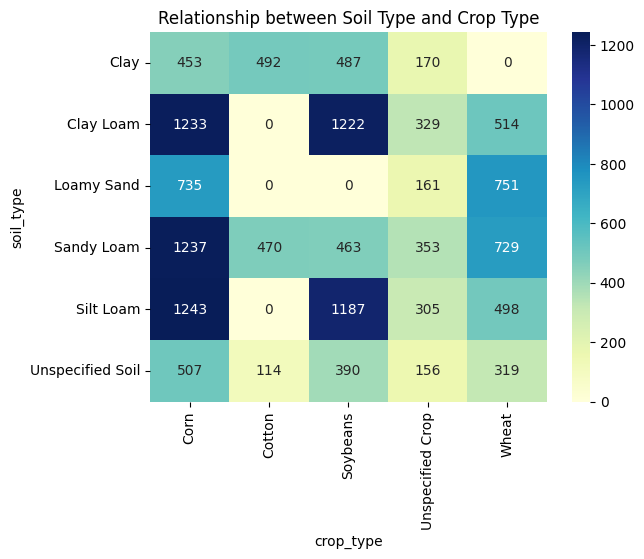

In [37]:
# Plotting the contingency table as a heatmap
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Relationship between Soil Type and Crop Type')
plt.show()

**Interpretation:**
- **Corn** grows best in **Sandy Loam** (1237), **Silt Loam** (1243), and **Clay Loam** (1233) but also appears in **Loamy Sand** (735) and **Clay** (453).
- **Cotton** is primarily found in **Clay** (492) and **Sandy Loam** (470)
- **Soybeans** thrive in **Clay Loam** (1222), **Silt Loam** (1187), **Clay** (487), and **Sandy Loam** (463).
- **Wheat** grows mainly in **Loamy Sand** (751), **Sandy Loam** (729), and **Clay Loam** (514), with no presence in **Clay**.

This means that **Sandy Loam** and **Clay Loam** soils are generally well-suited for diverse crop production, while other crops like Cotton and Wheat have specific soil preferences.

In [25]:
# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Statistic:", chi2)
print("p-value:", p)

Chi-square Statistic: 3947.9713009422867
p-value: 0.0


In [31]:
# Group by soil type and crop type, and calculate the average yield per acre (or other metric)
avg_yield = df.groupby(['soil_type', 'crop_type'])['yield_per_acre'].mean().reset_index()
avg_yield

,soil_type,crop_type,yield_per_acre
0,Clay,Corn,61.405798
1,Clay,Cotton,60.890803
2,Clay,Soybeans,57.913697
3,Clay,Unspecified Crop,60.088133
4,Clay Loam,Corn,184.501264
5,Clay Loam,Soybeans,178.302981
6,Clay Loam,Unspecified Crop,178.997638
7,Clay Loam,Wheat,205.166704
8,Loamy Sand,Corn,79.094116
9,Loamy Sand,Unspecified Crop,70.656598


<Axes: xlabel='irrigation_type'>

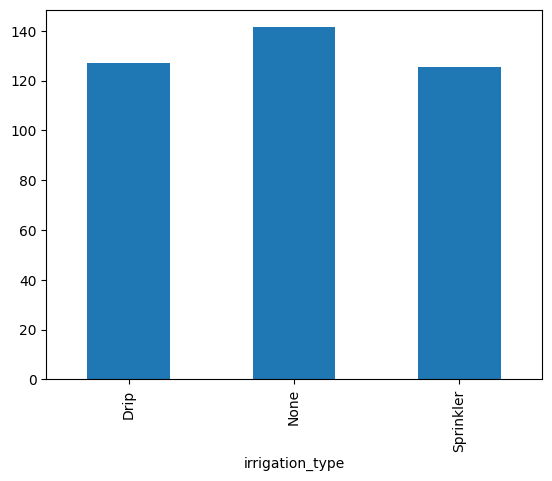

In [12]:
df.groupby('irrigation_type').mean(numeric_only = True)['yield_per_acre'].plot(kind = 'bar');

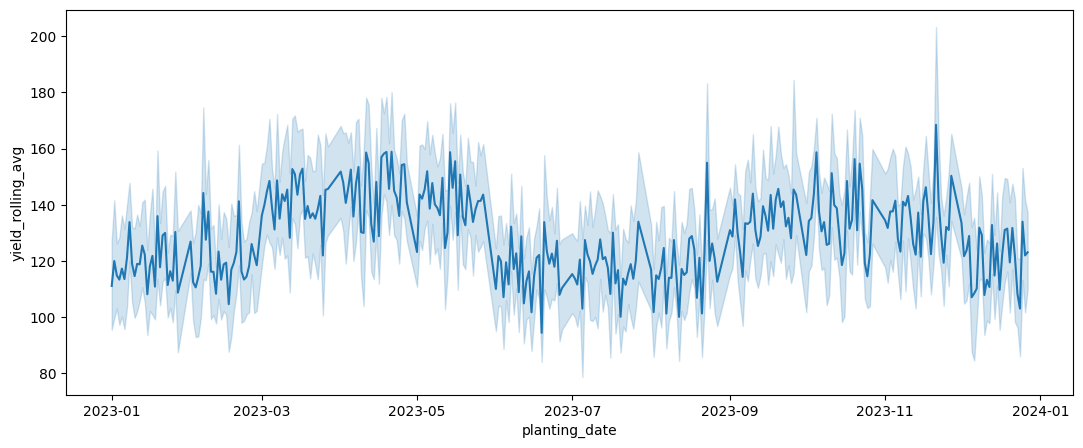

In [13]:
fig, ax = plt.subplots(figsize = (13, 5))
# Assuming a 7-day rolling average
df['yield_rolling_avg'] = df['yield_per_acre'].rolling(window=7).mean()

# Plotting the rolling average
sns.lineplot(data=df, x='planting_date', y='yield_rolling_avg');

In [20]:
season_report = df.groupby("season").agg(
    Farms_Count = ('field_id', 'count'), 
    Average_Yield = ('yield_per_acre', 'mean'),
    Average_Fertilizer = ('fertilizer_used', 'mean')
)
season_report

,Farms_Count,Average_Yield,Average_Fertilizer
season,,,
Fall,3318,166.853295,200.291901
Spring,3354,232.363577,201.803754
Summer,3261,40.787110,200.771991
Winter,3189,69.363497,199.269588
